# Portfolio Optimization

We found good stocks or assets to invest however how should we optimize our portfolio containing multiple tickers, we could simply go equal amounts, but it doesn't guarantee good performance.

Here we'll be looking ways to optimize your portfolio with simple codes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import seaborn as sns
sns.set()

In [2]:
tickers = ['SPLG', 'IOO', 'EWY', 'DXJ']
startdate = '2017-10-01'
df = pdr.get_data_yahoo(tickers, start=startdate)['Adj Close']
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
df

[*********************100%***********************]  4 of 4 completed


,DXJ,EWY,IOO,SPLG
Date,,,,
2017-10-02,50.342567,64.401413,41.151047,27.597944
2017-10-03,50.681973,65.015465,41.318722,27.712423
2017-10-04,50.581070,65.099205,41.225574,27.759148
2017-10-05,50.535210,65.592316,41.500378,27.915674
2017-10-06,50.461819,65.341103,41.477085,27.889975
...,...,...,...,...
2021-05-27,61.189999,90.790001,69.940002,49.299999
2021-05-28,61.439999,92.029999,69.980003,49.369999
2021-06-01,61.110001,93.459999,69.980003,49.349998


### Calculate returns and risks

In [3]:
window = 252 # avg stock market open date

daily_ret = df.pct_change() # daily return
annual_ret = daily_ret.mean() * 252 # annual return (daily mean * 252 days)
daily_cov = daily_ret.cov() # daily risk is calculated with `cov()`, estimate covariance matrix
annual_cov = daily_cov * 252 # annual risk 

port_ret = []
port_risk = []
port_weight = []

In [4]:
daily_ret

,DXJ,EWY,IOO,SPLG
Date,,,,
2017-10-02,NaN,NaN,NaN,NaN
2017-10-03,0.006742,0.009535,0.004075,0.004148
2017-10-04,-0.001991,0.001288,-0.002254,0.001686
2017-10-05,-0.000907,0.007575,0.006666,0.005639
2017-10-06,-0.001452,-0.003830,-0.000561,-0.000921
...,...,...,...,...
2021-05-27,0.005753,-0.008518,-0.002567,0.000406
2021-05-28,0.004086,0.013658,0.000572,0.001420
2021-06-01,-0.005371,0.015538,0.000000,-0.000405


In [5]:
annual_cov

,DXJ,EWY,IOO,SPLG
DXJ,0.050767,0.044592,0.038196,0.039431
EWY,0.044592,0.078541,0.044695,0.045435
IOO,0.038196,0.044695,0.042762,0.043722
SPLG,0.039431,0.045435,0.043722,0.046756


## Monte Carlo simulation

A Monte Carlo simulation is a model used to predict the probability of different outcomes when the intervention of random variables is present. Monte Carlo simulations help to explain the impact of risk and uncertainty in prediction and forecasting models.

Here we're going to create 20,000 different portfolio with different weights of each tickers.

In [6]:
for _ in range(20000): # for loop, use `_`  when ignoring index
    weights = np.random.random(len(tickers)) # create random number array
    weights /= np.sum(weights) # divide above random array by sum ,make it total 1
    
    returns = np.dot(weights, annual_ret) # multiply above portfolio weight array to annual return, gets total return
    # multiply annual covariance to weight array and multiply to weight array transpose. Finally `sqrt()` to get 
    # total risk of portfolio
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 
    
    # add 20,000 portfolio's returns, risk and weights to each list
    port_ret.append(returns)
    port_risk.append(risk)
    port_weight.append(weights)
    
portfolio = {'Returns': port_ret, 'Risk': port_risk}
for i, s in enumerate(tickers):
    portfolio[s] = [weight[i] for weight in port_weight]
df_port = pd.DataFrame(portfolio)
df_port = df_port[['Returns', 'Risk'] + [s for s in tickers]]

In [13]:
portfolio;

In [8]:
df_port

,Returns,Risk,SPLG,IOO,EWY,DXJ
0,0.134603,0.212096,0.406679,0.149324,0.015513,0.428484
1,0.164956,0.209660,0.025184,0.106808,0.613807,0.254200
2,0.152163,0.213273,0.210184,0.182994,0.041890,0.564932
3,0.146981,0.227973,0.086165,0.484641,0.361935,0.067259
4,0.128368,0.206731,0.452047,0.044546,0.422783,0.080625
...,...,...,...,...,...,...
19995,0.158803,0.222168,0.036105,0.371121,0.218909,0.373864
19996,0.133238,0.213307,0.389215,0.201844,0.074951,0.333990
19997,0.127697,0.221065,0.356321,0.371070,0.189369,0.083239
19998,0.140918,0.217060,0.218756,0.325584,0.337488,0.118173


Plot Monte Carlo simulation with `scatter()`

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


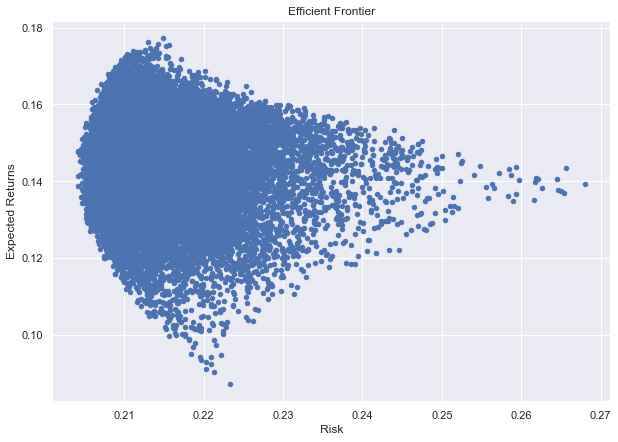

In [9]:
df_port.plot.scatter(x='Risk', y='Returns', figsize=(10,7), grid=True)
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

## Sharpe Ratio

The Sharpe ratio measures the performance of an investment (e.g., a security or portfolio) compared to a risk-free asset, after adjusting for its risk.

It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment (i.e., its volatility). It represents the additional amount of return that an investor receives per unit of increase in risk.

It was named after William F. Sharpe who developed it in 1966.

[*********************100%***********************]  4 of 4 completed


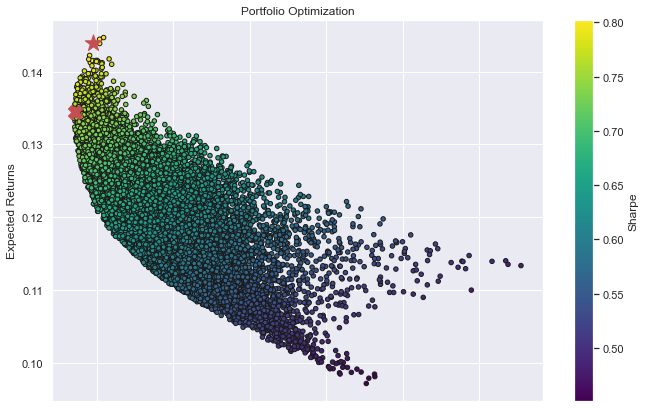

In [14]:
tickers = ['SPLG', 'IOO', 'EWY', 'DXJ']
startdate = '2014-10-01'
df = pdr.get_data_yahoo(tickers, start=startdate)['Adj Close']
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

window = 252 # avg stock market open date

daily_ret = df.pct_change() # daily return
annual_ret = daily_ret.mean() * 252 # annual return (daily mean * 252 days)
daily_cov = daily_ret.cov() # daily risk is calculated with `cov()`, estimate covariance matrix
annual_cov = daily_cov * 252 # annual risk 

port_ret = []
port_risk = []
port_weight = []
sharpe_ratio = []

for _ in range(20000): # for loop, use `_`  when ignoring index
    weights = np.random.random(len(tickers)) # create random number array
    weights /= np.sum(weights) # divide above random array by sum ,make it total 1
    
    returns = np.dot(weights, annual_ret) # multiply above portfolio weight array to annual return, gets total return
    # multiply annual covariance to weight array and multiply to weight array transpose. Finally `sqrt()` to get 
    # total risk of portfolio
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) 
    
    # add 20,000 portfolio's returns, risk and weights to each list
    port_ret.append(returns)
    port_risk.append(risk)
    port_weight.append(weights)
    sharpe_ratio.append(returns/risk) # Sharpe ratio
    
portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(tickers):
    portfolio[s] = [weight[i] for weight in port_weight]
df_port = pd.DataFrame(portfolio)
df_port = df_port[['Returns', 'Risk', 'Sharpe'] + [s for s in tickers]]

max_sharpe = df_port.loc[df_port['Sharpe'] == df_port['Sharpe'].max()]
min_risk = df_port.loc[df_port['Risk'] == df_port['Risk'].min()]

df_port.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', # By sharpe ratio colormap to `viridis`
                edgecolors='k', figsize=(11,7), grid=True)
plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r',
           marker='*', s=300) # Make red * max sharpe ratio 
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r',
           marker='X', s=200) # Make Min risk red `X` 
plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [15]:
max_sharpe

,Returns,Risk,Sharpe,SPLG,IOO,EWY,DXJ
1251,0.143906,0.179471,0.801833,0.01022,0.000645,0.160378,0.828757


In [16]:
min_risk

,Returns,Risk,Sharpe,SPLG,IOO,EWY,DXJ
10105,0.134464,0.177126,0.759145,0.004092,0.003899,0.630405,0.361603
